# Alignment of SMP and Snow Pits / Evaluation of Proksch (P15) coefficients
*Josh King and Mike Brady, Environment and Climate Change Canada, 2020*

This workbook introduces a snow on sea ice calibration procedure for SMP-derived estimates of density first introduced in [Proksch, et al., 2015](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2014JF003266). Where indicated, the work modifies portions of the [SMP python package from SLF](https://github.com/slf-dot-ch/snowmicropyn) and uses a number of open source community packages to facilitate processing.

I'm still not great at GIS in python so the maps in the publication were done in ESRI ArcMap.

### ***Alignment takes a long time due to the large number of scaling candidates. If you want to skip that part and just load the result set, set `skip_alignment` below to `True`.***

### Notes on settings and constants
**CUTTER_SIZE** defines the half height in mm of the density cutter used as reference. Can be changed to accommodate different sampler sizes. No need to change this for ECCC data. 

**WINDOW_SIZE** defines the size of the rolling window used in SLF shot noise calculations. A 5 mm window was used in [Proksch, et al., 2015](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2014JF003266) when there was separation between the SMP and density cutter. Increasing the window reduces sensitivity to sharp transitions and reduces resolution of the analysis. However, moving to something like 2.5 mm makes comparison difficult as some of the very fine structure resolved is very different over the ~10 cm separation between the SMP and density profiles. 

**NUM_TESTS** defines how many random scaling configurations to test against when attempting to align the SMP and snow pit data. We brute-force the alignment in our paper so `NUM_TESTS` must be large to ensure the test space searched is sufficient. A lower number of tests risks poor alignment and therefore poor calibration. In the paper we use 10k permutations.

**MAX_STRETCH_LAYER** and **MAX_STRETCH_OVERALL** define how much an individual layer can be eroded or dilated, and the maximum change in total length of the SMP profile, respectively. We allow a rather large 70% change to individual layers to accommodate pinching out but restrict the total change to 10% to avoid overfitting.

**H_RESAMPLE** and **L_RESAMPLE** define the resampled resolution of the SMP and the layer size used for matching profiles. These terms are interactive with the layer stretching and should be evaluated carefully if changed.

In [1]:
# Community packages
import os 
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy import stats
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

# Local packages
import smpfunc # SMP helper functions

# Import SLF SMP Package
# To ensure compatablility build from the environment.yml
from snowmicropyn import Profile, proksch2015, loewe2012

# Import field data
pit_summary = pd.read_csv("./data/Pit/pit_summary.csv")#Y:\mosaic\data\processed\thermal_conductivity_XF\metadata_SMPsel.xlsx")
pit_density = pd.read_csv("./data/Pit/pit_density.csv")
input_data = os.path.abspath("./data/SMP/Calibration") #Y:\mosaic\data\raw\pack_ice\snowpit\sn_smp_ALL")
pit_density['BOTTOM'] = pit_density['BOTTOM'] - pit_density['Height correction mm']
pit_density['TOP'] = pit_density['TOP'] - pit_density['Height correction mm']


# Set constants
CUTTER_SIZE = 2.5  # Half the height of the density cutter in mm
WINDOW_SIZE = 5  # SMP analysis window in mm
H_RESAMPLE = 1  # Delta height in mm for standardized SMP profiles
L_RESAMPLE = 25  # Layer unit height in mm for SMP matching... was 50 mm
MAX_STRETCH_LAYER = 0.75  # Max layer change in % of height
MAX_STRETCH_OVERALL = 0.15  # Max profile change in % of total height
NUM_TESTS = 10000  # Number of scaling candidates to generate for alignment testing 

# Set conditions
skip_alignment = True # Set as true to just load the results from a pickle instead of reprocessing
paper_conditions = True # Set as true to reproduce the paper results with seeding

# Small differences in comparison to the paper will occur if a seed is not set.
# This is mainly because we use a brute-force approach for matching the SMP and 
# snow pit profiles with a modest search size (specified by NUM_TESTS).
if paper_conditions:
    np.random.seed(2019) 

os.makedirs('./output/figures/SSA', exist_ok=True)    

# Helper functions
def rmse(data):
    return np.sqrt(np.mean(data**2))

def load_smp(smp_file):
    p = Profile.load(smp_file)
    p = smpfunc.preprocess(p, smoothing = 0, noise_threshold = 0.01)
    ground  = p.detect_ground()
    surface  = p.detect_surface()
    return p

Load the SMP calibration profiles at each snow pit (n = 25).  
Preprocess each SMP file to remove noise and detect ground and air interfaces.

In [2]:
file_list = []
for file in os.listdir(input_data):
    if file.endswith(".pnt"):
        file_list.append(os.path.join(input_data, file))
        
smp_data = [load_smp(file) for file in file_list]

print("SMP calibration profiles loaded: {}".format(len(smp_data)))

Latitude value -99999.0 invalid, replacing by None (file S31H0820)
Longitude value None invalid, replacing by None (file S31H0820)
Latitude value -99999.0 invalid, replacing by None (file S49M1106)
Longitude value None invalid, replacing by None (file S49M1106)
Latitude value -99999.0 invalid, replacing by None (file S49M1109)
Longitude value None invalid, replacing by None (file S49M1109)
Latitude value -99999.0 invalid, replacing by None (file S49M2238)
Longitude value None invalid, replacing by None (file S49M2238)
Latitude value -99999.0 invalid, replacing by None (file S49M2286)
Longitude value None invalid, replacing by None (file S49M2286)
Latitude value -99999.0 invalid, replacing by None (file S49M2291)
Longitude value None invalid, replacing by None (file S49M2291)


SMP calibration profiles loaded: 40


### Summary information on the snow pit properties

**pit_summary** holds summary information on all now pits. Here is a breakdown of the variables within:
  - **ID**: Site identification code  
  - **IOP**: Campaign identity code where a = Alert and e = Eureka  
  - **ICE**: Ice surface type where m = MYI and f = FYI  
  - **DOY**: Day of year  
  - **Date**: Date snow pit was completed  
  - **SITEID**: Campaign-specific site identification code  
  - **LAT** and **LON** decimal degree WGS-84 coordinates  
  - **PITFILE**: Internal ECCC snow pit file names (Available on request)  
  - **SMPF**: Last 4 digits of the corresponding SMP file name  
  - **MPD** Average of nearby Magnaprobe measured snow thickness  
  - **SD**: Total snow pit thickness  
  - **PD**: Operator-recorded SMP penetration, better to check directly from SMPF  
  - **OFF**: Offset between retracted SMP tip and the snow surface. When mounted on the support structure this generally does not change unless there is settling  
  - **NOTESMP**: SMP operator notes  
  - **NOTESPIT**: Snow pit operator notes  

In [3]:
pit_summary.head(1)

,ID,IOP,ICE,DOY,Date,SITEID,LAT,LON,PITFILE,SMPF,MPD,SD,PD,OFF,NOTESMP,NOTESPIT
0,PS122/2_19-144,f1,NaN,10,10/01/2020,FR,87.175694,112.794265,Y:\data\processed\snowpits\microct90\Event_pro...,S49M0829,NaN,0.37,NaN,NaN,NaN,NaN


In [4]:
print('SMP profile total: %i' % len(smp_data))
print('Snow pit total: %i' % len(pit_summary))
print('\nDensity total: %i' % len(pit_density))
print('\nSnow pits by campaign:')
print(pit_summary.IOP.value_counts())
print('\nSnow pits by ice type:')
print(pit_summary.ICE.value_counts())

# Note: The small number of recent snow measurements were rolled into rounded classification
#       for the paper. In the future many more measurements are needed to chracterize recent snow

print('\nDensity measurements by layer type:')
print(pit_density.TYPE.value_counts()) ## This was originally pit_density.TYPE.value_counts() : F,D,R(I, N) 

SMP profile total: 40
Snow pit total: 58

Density total: 2291

Snow pits by campaign:
IOP
f1    58
Name: count, dtype: int64

Snow pits by ice type:
Series([], Name: count, dtype: int64)

Density measurements by layer type:
TYPE
N    2291
Name: count, dtype: int64


### Extraction of corresponding snow pit density and SMP properties
This section relies on functions imported from `smpfunc.py`. We iterate through all the SMP profiles that are associated with snow pits and do the following:

1. Restructure the snow pit density estimates into a dataframe (`density_df`)  
2. Make first guess estimates of density using the P15 coefficients (`p2015`)  
3. Resample the SMP and snow pit arrays to a common thickness axis  
4. Generate scaling candidates (`random_tests`) according to `L_RESAMPLE`, `NUM_TESTS`, `MAX_STRETCH_OVERALL`, and `MAX_STRETCH_LAYER` 
5. Scale the profiles and extract the SMP estimates corresponding with each density cutter measurement (`compare_profiles`)  
6. Evaluate retrieval skill according to correlation and rmse (`retrieved_skill`)  
7. Save properties of the best scaling candidate for further analysis  

In [7]:
import snowmicropyn


comparison_df = pd.DataFrame()
min_scaling_coeff = []

# if not skip_alignment:
for smp in smp_data:
        smp_file_num = str(smp.name)
        print(smp_file_num)#[-4:])
        pit_df  = pit_summary[pit_summary['SMPF'] == smp_file_num] # Select the matching pit
        density_df = pit_density[pit_density['ID'] == pit_df['ID'].values[0]]
        density_df = density_df.assign(relative_height=np.abs(((density_df['TOP']) - CUTTER_SIZE) - density_df['TOP'].max()).values)
        
        # Make first guess at microstructure based on original profile
        # l2012 = loewe2012.calc(smp.samples_within_snowpack(), window=WINDOW_SIZE, overlap=50) #added overlap!!!
        p2015 = loewe2012.calc(smp.samples_within_snowpack(), window=WINDOW_SIZE, overlap=50) ### this is now the same as L
    
        # p2015['P2015_density']  = 420.47 + (102.47 * np.log(p2015.L2012_f0)) + (-121.15 * np.log(p2015.L2012_f0) * p2015.L2012_L ) + (-169.96 * p2015.L2012_L)
        p2015['K20b_density']  = 312.54 + (50.27  * np.log(p2015.force_median)) + (-50.26 * np.log(p2015.force_median)  * p2015.L2012_L ) + (-85.35 * p2015.L2012_L)
        p2015['lc'] = 0.131 + (0.355 * p2015.L2012_L ) + (0.0291 * np.log(p2015.force_median))
        P2015_ssa = 4 * (1 - (p2015['K20b_density'] / 917.)) / p2015['lc'] # 1/mm (Equation 12 in publication)
        p2015['P2015_ssa'] = P2015_ssa * 1000 / 917. # m^2/kg

    
        # Estimate offset of the snow depth and SMP profile
        smp_profile_height = p2015.distance.max()
        smp_height_diff = 0 # was pit_df.MPD.values*1000 - smp_profile_height

        # Create new SMP resampled arrays and determine the number of layers
        depth_array = np.arange(0, p2015.distance.max() + smp_height_diff, H_RESAMPLE)
        density_array = np.interp(depth_array,p2015.distance,p2015.K20b_density)
        ssa_array = np.interp(depth_array,p2015.distance,p2015.P2015_ssa)
        force_array = np.interp(depth_array,p2015.distance,p2015.force_median)
        l_array = np.interp(depth_array,p2015.distance,p2015.L2012_L)

        smp_df = pd.DataFrame({'distance': depth_array, 
                               'density': density_array,
                               'ssa': ssa_array,
                               'force_median': force_array,
                               'l': l_array})

        # Generate a selection of random transformations to evaluate brute-force alignment
        # We use a brute force approach because there was no gradient that could be used to optimize the relationship
        num_sections = np.ceil(len(smp_df.index)/L_RESAMPLE).astype(int)
        random_tests = [smpfunc.random_stretch(x, MAX_STRETCH_OVERALL, MAX_STRETCH_LAYER) for x in np.repeat(num_sections, NUM_TESTS)] 

        scaled_profiles = [smpfunc.scale_profile(test, smp_df.distance.values, smp_df.density.values, L_RESAMPLE, H_RESAMPLE) for test in random_tests]
        compare_profiles = [smpfunc.extract_samples(dist, rho, density_df.relative_height.values, CUTTER_SIZE) for dist, rho in scaled_profiles]
        compare_profiles = [pd.concat([profile, density_df.reset_index()], axis=1, sort=False) for profile in compare_profiles]
        retrieved_skill = [smpfunc.calc_skill(profile, CUTTER_SIZE) for profile in compare_profiles]
        retrieved_skill = pd.DataFrame(retrieved_skill,columns = ['r','rmse','rmse_corr','mae'])

        min_scaling_idx = retrieved_skill.sort_values(['r', 'rmse_corr'], ascending=[False, True]).head(1).index.values
        min_scaling_coeff.append(random_tests[int(min_scaling_idx)])
        
        dist, scaled_l =  smpfunc.scale_profile(min_scaling_coeff[-1], smp_df.distance.values, smp_df.l.values, L_RESAMPLE, H_RESAMPLE)
        dist, scaled_force_median = smpfunc.scale_profile(min_scaling_coeff[-1], smp_df.distance.values, smp_df.force_median.values, L_RESAMPLE, H_RESAMPLE)

        result = compare_profiles[int(min_scaling_idx)].assign(l=smpfunc.extract_samples(dist, scaled_l, density_df.relative_height.values, CUTTER_SIZE).mean_samp,
                                                  force_median=smpfunc.extract_samples(dist, scaled_force_median, density_df.relative_height.values, CUTTER_SIZE).mean_samp)
        # comparison_df = comparison_df.append(result, ignore_index=True) ## no df append in python 2.0.0
        comparison_df = pd.concat([comparison_df, result], ignore_index=True) 

        print("Finished with {}".format(smp.name))
    
# Summary of scaling
smp_thickness = [p.samples_within_snowpack().distance.max() for p in smp_data]
scaling_total = [s.sum() for s in min_scaling_coeff]
scaling_mean_abs =  np.round(np.abs(np.array(scaling_total)).mean(), 3)
print('Average scaling: %0.3f' % scaling_mean_abs) # in %

# save the results to a local file since tbe brute-force method takes a while to compute
comparison_df.to_pickle("./output/smp_pit_comparison.pkl")


# else:
    # Load previously-generated results if desired
    # comparison_df = pd.read_pickle('./output/smp_pit_comparison.pkl')

S31H0521


C:\Users\amyrm\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\amyrm\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\amyrm\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\amyrm\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\amyrm\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\amyrm\anaconda3\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_k

Finished with S31H0521
S31H0532



KeyboardInterrupt



In [8]:
print(comparison_df)

    count_samp   mean_samp  median_samp  stdev_samp  index  Index  Bin  \
0            2  302.579574   302.579574    0.560426   1391      4    9   
1            6  250.671627   236.965383   30.443115   1392      5   10   
2            6  235.038446   228.638487   19.046244   1393      6   11   
3            6  270.949809   271.955707   10.760349   1394      7   19   
4            6  294.365412   293.751043    8.890766   1395      8   20   
5            6  310.598316   315.588186   13.027618   1396      9   21   
6            6  303.705775   303.421440    9.788236   1397     10   22   
7            6  285.069601   285.910774    6.623326   1398     11   23   
8            6  275.160649   273.073259   10.882406   1399     12   24   
9            6  287.182455   290.131530    8.355614   1400     13   25   
10           6  268.290759   269.458382    4.972394   1401     14   26   
11           6  243.434714   241.282932    9.342591   1402     15   27   
12           6  231.318644   231.55669

### Filtering of results
Apply a few rules to clean up the data:
1. Drop comparisons where any field is not a number (`NaN`), this can occur when a density sample overlaps with no SMP data (ie. depth hoar omissions)
2. Drop comparisons where the density cutter is not fully within the SMP profile (identified by the SMP count)
3. Drop comparisons where there is new snow or ice in the sample (Not enough samples to support robust analysis)

In [6]:
result = comparison_df.dropna() 
result = result[result['count_samp']>=CUTTER_SIZE*2] # Remove comparisons outside the profile
# result = result[~result['TYPE'].isin(['N', 'I'])] # Remove new snow and ice because we don't have enough samples
result['error'] = result['mean_samp']-result['RHO']
result.head()

,count_samp,mean_samp,median_samp,stdev_samp,index,Index,Bin,ScannerID,RHO,SSA,...,TOP,Height correction mm,ID,Location,Datetime,TYPE,relative_height,l,force_median,error
1,6.0,250.671627,236.965383,30.443115,1392.0,5.0,10.0,4900.0,251.664707,9.886767,...,105.0,-50.0,PS122/3_37-132,RS4,26/04/2020 14:30,N,147.5,0.879808,4.189982,-0.993080
2,6.0,235.038446,228.638487,19.046244,1393.0,6.0,11.0,4900.0,261.534510,9.835250,...,110.0,-50.0,PS122/3_37-132,RS4,26/04/2020 14:30,N,142.5,0.976932,2.959606,-26.496064
3,6.0,270.949809,271.955707,10.760349,1394.0,7.0,19.0,4900.0,304.558297,12.210600,...,150.0,-50.0,PS122/3_37-132,RS4,26/04/2020 14:30,N,102.5,0.691499,2.968832,-33.608487
4,6.0,294.365412,293.751043,8.890766,1395.0,8.0,20.0,4900.0,352.791995,11.915575,...,155.0,-50.0,PS122/3_37-132,RS4,26/04/2020 14:30,N,97.5,0.568636,3.989572,-58.426583
5,6.0,310.598316,315.588186,13.027618,1396.0,9.0,21.0,4900.0,337.253930,11.225220,...,160.0,-50.0,PS122/3_37-132,RS4,26/04/2020 14:30,N,92.5,0.481754,4.464446,-26.655614


### Compare extracted SMP density against *in situ*
SMP density estimates using the Proksch et. al. 2015 coefficients are compared here

In [7]:
# P2015 evaluation stats
p2015_rmse = np.sqrt(np.mean(result['error']**2))
p2015_bias = (result['error']).mean()
p2015_r2 = np.ma.corrcoef(result['mean_samp'],result['RHO'])[0, 1]**2
p2015_n = len(result['mean_samp'])
p2015_p = stats.pearsonr(result['mean_samp'],result['RHO'])[1]

print('Proksch et al. 2015 Eval.')
print('N: %i' % p2015_n)
print('RMSE: %0.1f' % np.round(p2015_rmse))
print('bias: %0.1f' % np.round(p2015_bias))
print('r^2: %0.2f' % p2015_r2)

Proksch et al. 2015 Eval.
N: 784
RMSE: 75.0
bias: -25.0
r^2: 0.10


C:\Users\amyrm\AppData\Local\Temp\ipykernel_10380\2345899478.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax1.plot([line_start, line_end], [line_start, line_end],


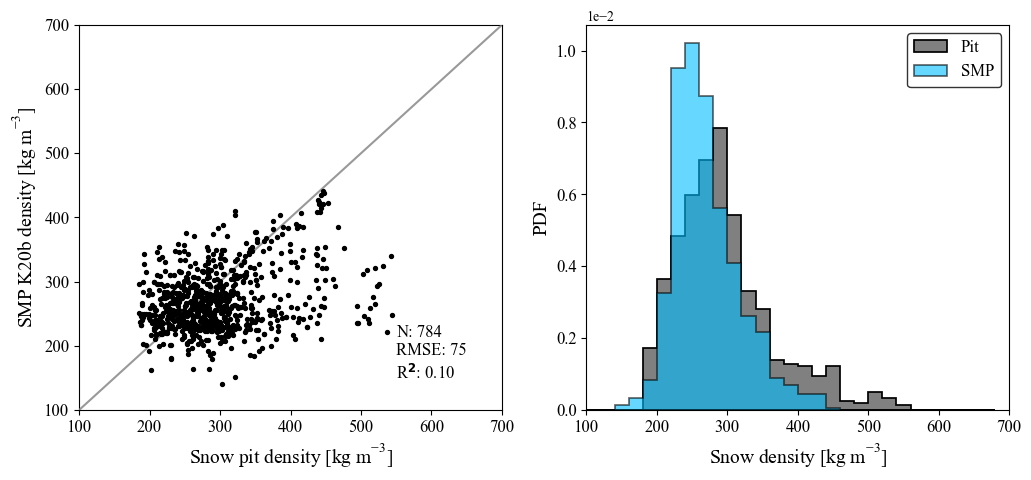

In [14]:
# Paper figure 4 (Top) with caption
# 'Evaluation of the SMP density model parametrization of Proksch et al. (2015) (P15; Top) 
#  and recalibrated coefficients for snow on sea ice (K20b; Bottom). 
#  In both cases the model is evaluated against manual density cutter measurements of snow density.'

axis_value_size = 12
axis_label_size = 14

line_start = 100
line_end = 700
point_size = 8

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(12,5))
ax1.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax2.tick_params(axis='both', which='major', labelsize=axis_value_size)

ax1.scatter(result['RHO'], result['mean_samp'], 
            s = point_size, color ='black', zorder = 1000)
ax1.plot([line_start, line_end], [line_start, line_end], 
         'k-', color = 'gray' ,alpha= 0.8, zorder = 500)

ax1.set_xlim(line_start,line_end)
ax1.set_ylim(line_start,line_end)

rho_bin_size = 20 #in kg m-3
common_bin = np.arange(line_start,line_end, rho_bin_size)
hist_kws = dict(density=True, bins=common_bin, histtype="stepfilled", linewidth=1.25)
ax2.ticklabel_format(axis='y',style='sci', scilimits=(1,5), useMathText=False)

ax2.hist(result['RHO'], alpha = 1, edgecolor="black", 
         color = 'grey', label = 'Pit', **hist_kws)
ax2.hist(result['mean_samp'], alpha = 0.6, edgecolor="black", 
         color = 'deepskyblue', label = 'SMP', **hist_kws)

ax1.text(550, 150,'N: %i \nRMSE: %i \nR$^2$: %0.2f'%(p2015_n, p2015_rmse, p2015_r2),  fontsize=12)
ax1.set_ylabel('SMP K20b density [kg m$\mathregular{^{-3}}$]', fontsize=axis_label_size)
ax1.set_xlabel('Snow pit density [kg m$\mathregular{^{-3}}$]', fontsize=axis_label_size)
ax2.set_ylabel('PDF', fontsize=axis_label_size)
ax2.set_xlabel('Snow density [kg m$\mathregular{^{-3}}$]', fontsize=axis_label_size)
ax2.legend(edgecolor = 'black',  fontsize=axis_value_size)
ax2.set_xlim(line_start,line_end);

In [9]:
# Error as a % of mean density
np.round(rmse(result.error)/ result['RHO'].mean(),2)

0.25

In [10]:
# RMSE by layer type
result.groupby('TYPE')['error'].apply(rmse)

TYPE
N    75.234016
Name: error, dtype: float64

In [11]:
# Errors by campaign (a = alert, e = eureka)
campaign_tag = []
ice_tag = []
lat_tag = []
lon_tag = []
for x in result['ID']:
    ice_tag.append(np.asarray(pit_summary[pit_summary['ID']== x]['ICE'].values))
    campaign_tag.append(np.asarray(pit_summary[pit_summary['ID']== x]['IOP'].values))
    lat_tag.append(np.asarray(pit_summary[pit_summary['ID']== x]['LAT'].values))
    lon_tag.append(np.asarray(pit_summary[pit_summary['ID']== x]['LON'].values))

result['campaign'] = np.hstack(campaign_tag)
result['ice_type'] = np.hstack(ice_tag)
result['lat'] = np.hstack(lat_tag)
result['long'] = np.hstack(lon_tag)

result.groupby('campaign')['error'].apply(rmse)

campaign
f1    75.234016
Name: error, dtype: float64

In [12]:
# Errors by ice type (f = fyi, m = myi)
result.groupby('ice_type')['error'].apply(rmse)

Series([], Name: error, dtype: float64)

In [13]:
# Export the dataset
result.to_pickle("./output/smp_pit_filtered.pkl")